In [18]:
import sys
root_dir = '/home/gddaslab/mxp140/tcr_project_ultimate'
sys.path.append(root_dir)

import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from calculate_probabilities import calc_probs_for_single_tcr
from pdf import ci_pdf, plot_pdf, generate_configuration_per_tcr

In [19]:
full_data = pd.read_csv(f'{root_dir}/data/BrMET_and_GBM_data.csv', sep=',')

In [20]:
patients = ['BrMET009', 'GBM052']

In [21]:
ci_dfs_dict_list = []
for patient_id in patients[:]:
    patient_data = full_data[full_data["Patient"]==patient_id]
    clone_count_values = patient_data['counts']
    
    ci_dfs_dict = {}
    size=50000
    least_number_of_observations = 10
    ################### for original kr ############
    with h5py.File(f'{root_dir}/results/probabilities/probs_{patient_id}.h5', 'r') as f:
        probs = f['result'][:]
        # probs = probs[:1000, :100]
        # print(f'{patient_id}:{probs.shape}')
    print(f'{patient_id}: Generating configuration for ORIGINAL', end='\r', flush=True)
    all_configs = generate_configuration_per_tcr(probs, size=size)
    ci_df = ci_pdf(all_configs, least_number_of_observations=least_number_of_observations)
    ci_df = ci_df[(ci_df['lower']!=ci_df['median']) &  (ci_df['median']!=ci_df['upper'])]
    ci_dfs_dict['original'] = ci_df
    
    ################### for uniform kr ############
    with h5py.File(f'{root_dir}/results/probabilities/probs_{patient_id}_uni0_test.h5', 'r') as f:
        probs = f['result'][:]
        # probs = probs[:1000, :100]
        # print(f'{patient_id}:{probs.shape}')
    print(f'{patient_id}: Generating configuration for UNIFORM', end='\r', flush=True)
    all_configs = generate_configuration_per_tcr(probs, size=size)
    ci_df = ci_pdf(all_configs, least_number_of_observations=least_number_of_observations)
    ci_df = ci_df[(ci_df['lower']!=ci_df['median']) &  (ci_df['median']!=ci_df['upper'])]
    ci_dfs_dict['uniform'] = ci_df
    
    ################### for mean kr ############
    file_path = '/home/gddaslab/mxp140/tcr_project_ultimate/results/results.xlsx'
    sheet_name = 'parameters_from_mean_kr_test'
    parameters_df = pd.read_excel(file_path, sheet_name=sheet_name)
    x1 = parameters_df[parameters_df['Patient']==patient_id]['x1'].values[0]
    x2 = parameters_df[parameters_df['Patient']==patient_id]['x2'].values[0] #result[1]
    mean_kr = parameters_df[parameters_df['Patient']==patient_id]['mean_scaled_kr'].values[0]
    # print(patient_id, x1, x2, mean_kr)
    M_max = 10000
    probability_values = calc_probs_for_single_tcr(mean_kr, x1, x2, M_max)
    n = len(clone_count_values)
    probs = np.array([probability_values]*n)
    print(f'{patient_id}: Generating configuration for MEAN', end='\r', flush=True)
    all_configs = generate_configuration_per_tcr(probs, size=size) 
    ci_df = ci_pdf(all_configs, least_number_of_observations=least_number_of_observations)
    ci_df = ci_df[(ci_df['lower']!=ci_df['median']) &  (ci_df['median']!=ci_df['upper'])]
    ci_dfs_dict['mean'] = ci_df
    
    ############
    ci_dfs_dict_list.append(ci_dfs_dict)
    

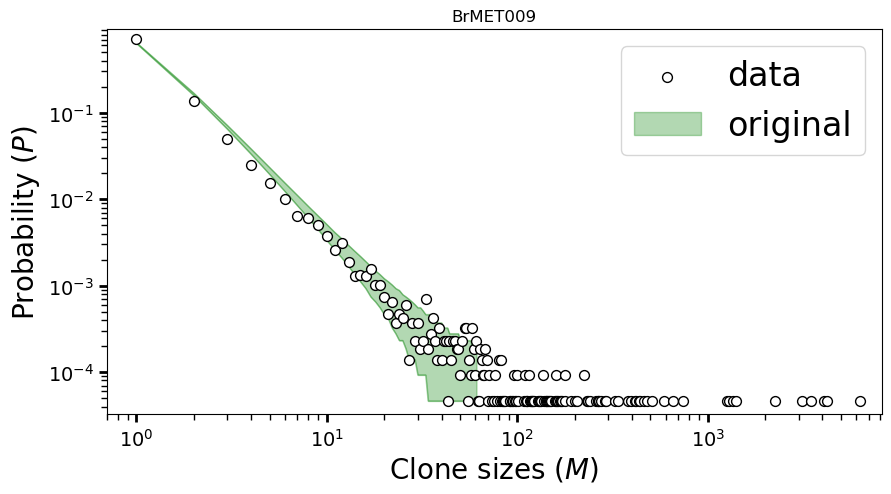

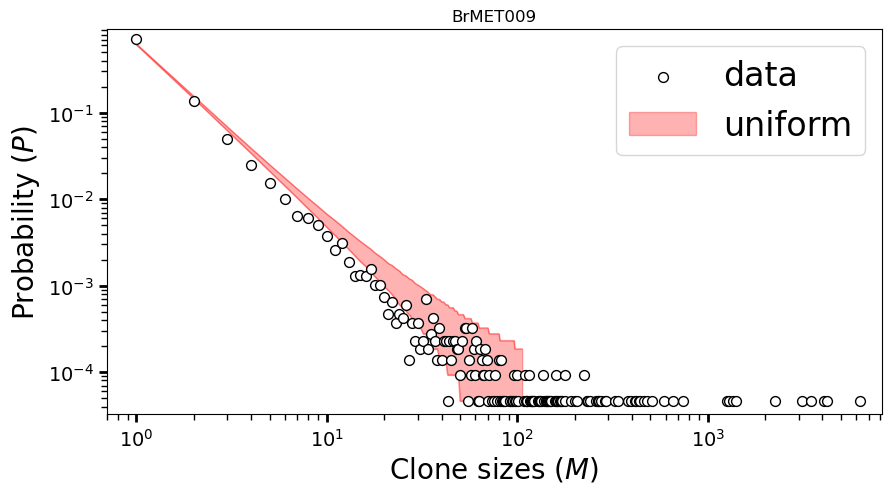

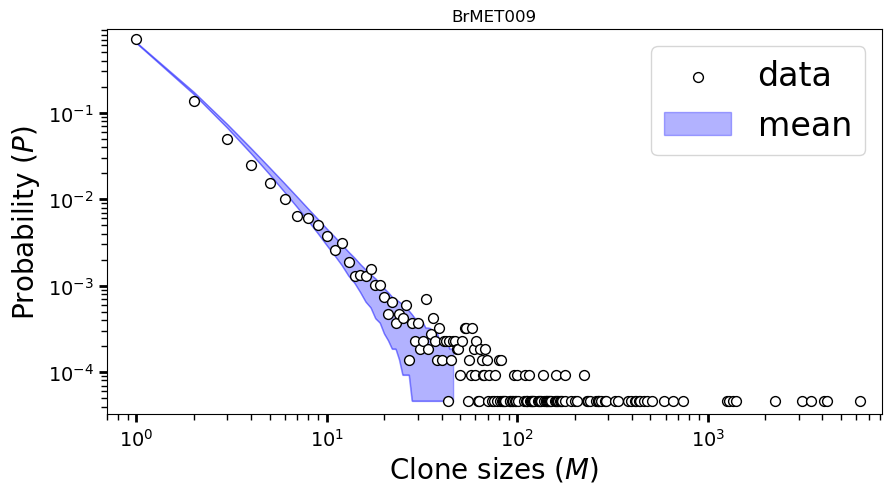

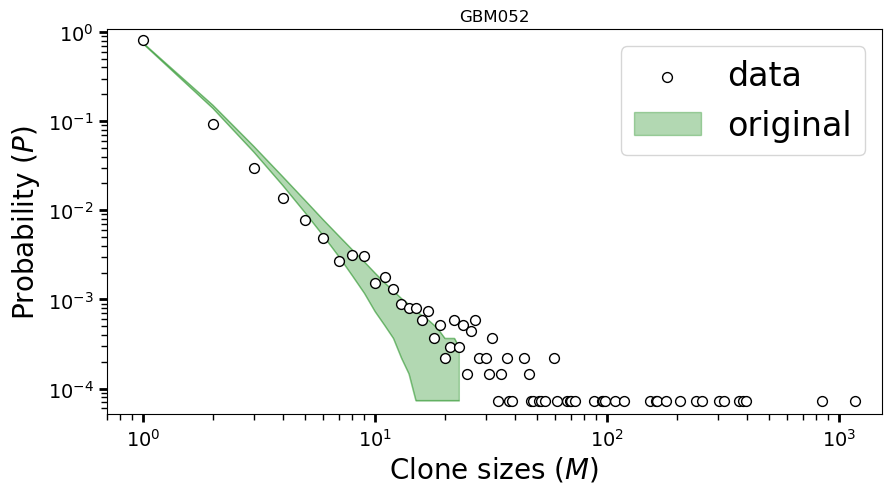

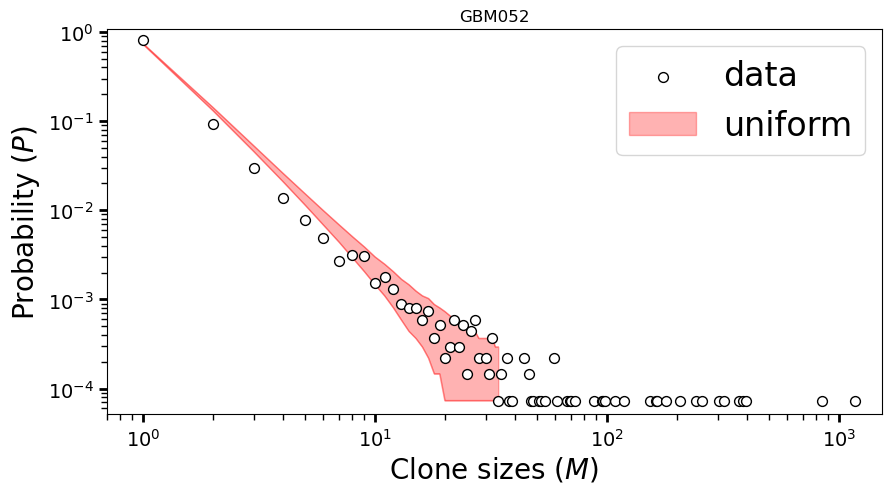

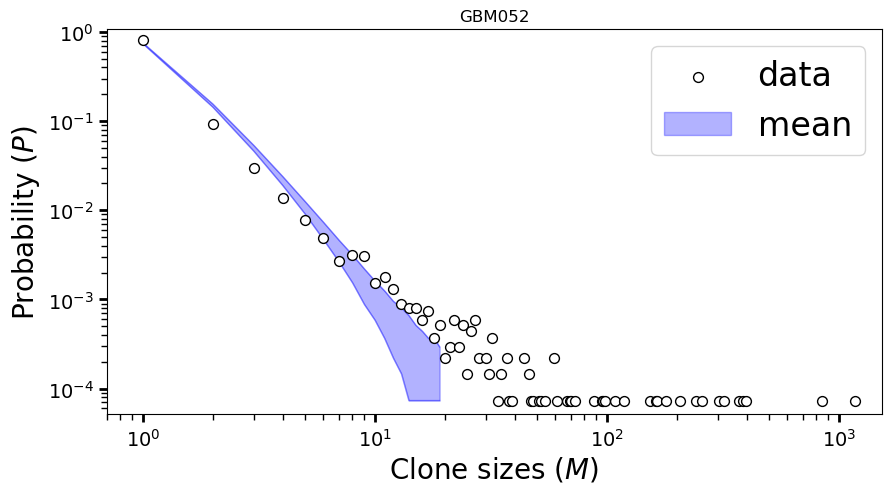

In [22]:
for i, patient_id in enumerate(patients[:]):
    ci_dfs_dict = ci_dfs_dict_list[i]
    colors_dict = {'original':'green', 'uniform':'red', 'mean':'blue'}
    for key in ci_dfs_dict.keys():
        patient_data = full_data[full_data["Patient"]==patient_id]
        clone_count_values = patient_data['counts']
        fig, ax = plot_pdf(clone_count_values)
        ci_df = ci_dfs_dict[key]
        color = colors_dict[key]
        ax.fill_between(ci_df['clone_size'], ci_df['lower'], ci_df['upper'], color=color, alpha=0.3, zorder=1, label=key)
        ax.plot(ci_df['clone_size'], ci_df['lower'], color=color, alpha=0.3, linewidth=1., zorder=1)
        ax.plot(ci_df['clone_size'], ci_df['upper'], color=color, alpha=0.3, linewidth=1., zorder=1)
        ax.legend(loc='best', fontsize=24)
        ax.set_title(patient_id)
        ax.set_xlabel(r"Clone sizes ($M$)", fontsize=20)
        ax.set_ylabel('Probability ($P$)', fontsize=20)
        ax.tick_params(axis='both', which='major', labelsize=14, length=6, width=2)
        ax.tick_params(axis='both', which='minor', labelsize=12, length=4, width=1)
        plt.show()